# HateBERT for Implicit hate speech detection

In [ ]:
# !pip install evaluate
# !pip install seqeval
# !pip install ipywidgets
# !pip install transformers datasets seqeval evaluate
# !pip install pyfunctional
# !pip install torch torchvision
# !pip install spacy
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy validate
# !pip install "numpy<2"
# !pip install "thinc<8.3.6"
# !pip install transformers
# !pip install --upgrade transformers
# !pip install 'accelerate>=0.26.0'
# !pip install nltk
# !pip install pandas


In [3]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tree import Tree
from nltk.stem.porter import PorterStemmer
import re
from collections import Counter
import string
import pandas as pd
# import spacy
# from spacy.tokens import Doc
# from spacy import displacy
# import benepar
from itertools import chain
import sklearn
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import scipy.stats
import pickle
import networkx as nx
import os, logging
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from itertools import combinations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import numpy as np
import matplotlib.pyplot as plt
import re
from datasets import load_dataset
from evaluate import load
from datasets import Dataset
import os

import csv

import pkg_resources
import subprocess
import sys

import numpy as np
from numpy import log, mean
from pandas import Series, DataFrame

from typing import List, Tuple, Union
import glob

from functional import seq
# from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from IPython.display import clear_output
from typing import Dict, List, Tuple, Union

from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, set_seed
from transformers import DataCollatorWithPadding


In [ ]:
model_checkpoint = "GroNLP/hateBERT"
task = "hate_detection"
batch_size = 16

In [ ]:
import torch
x = torch.rand(5, 3)
print(x)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
model = BertForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3
)

tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data analysis


Dataset 1: Class (implicit_hate, explicit_hate, not_hate labels) are in dataset "./implicit_hate_v1_stg1.tsv"

Dataset 2: Implicit class (white grievance, irony, stereotypical) are in dataset "./implicit_hate_v1_stg2_posts.tsv"

Dataset 3: Target groups (minority, immigrants) are in dataset "./implicit_hate_v1_stg3_posts.tsv"

In [ ]:
binary_labels_data = "implicit-hate-corpus/implicit_hate_v1_stg1_posts.tsv"
implicit_class_data = "implicit-hate-corpus/implicit_hate_v1_stg2_posts.tsv"
target_group_data = "implicit-hate-corpus/implicit_hate_v1_stg3_posts.tsv"

In [ ]:
df_stg1_posts = pd.read_csv(binary_labels_data, delimiter='\t')
print(df_stg1_posts)

                                                    post          class
0        " : jewish harvard professor noel ignatiev w...  implicit_hate
1       b.higher education is a part of european cult...       not_hate
2       has a problem with  " the whites " " and " " ...       not_hate
3       is yasir qadhi a hate preacher for calling ch...       not_hate
4       rt  " : how three million germans mass murder...       not_hate
...                                                  ...            ...
21475  Seeing prostitutes is morally wrong, but being...  implicit_hate
21476  I wonder how many females I raped today I spen...  implicit_hate
21477  Having a criminal record is more attractive to...  implicit_hate
21478  Another advantage of being a female: getting b...  implicit_hate
21479  If men are so privileged and women have it so ...  implicit_hate

[21480 rows x 2 columns]


In [ ]:
df_stg2_posts = pd.read_csv(implicit_class_data, delimiter='\t')
print(df_stg2_posts)

                                                   post   implicit_class  \
0       " : jewish harvard professor noel ignatiev w...  white_grievance   
1      rt : tune in today's jmt for my interview w /...            irony   
2     : : hate posters ? you want hate buddy ? read ...  white_grievance   
3     : hunt for white women : black racist serial k...    stereotypical   
4     : looks like he was a fan of the islamic jew-h...    stereotypical   
...                                                 ...              ...   
6341  Seeing prostitutes is morally wrong, but being...            irony   
6342  I wonder how many females I raped today I spen...            irony   
6343  Having a criminal record is more attractive to...    stereotypical   
6344  Another advantage of being a female: getting b...      inferiority   
6345  If men are so privileged and women have it so ...            irony   

     extra_implicit_class  
0                     NaN  
1                     NaN  
2  

In [ ]:
df_stg3_posts = pd.read_csv(target_group_data, delimiter='\t')
print(df_stg3_posts)

                                                    post            target  \
0       rt  " white privilege " " is when the gun jam...   minority groups   
1       rt  " white privilege " " is when the gun jam...      Black people   
2        if you are white in that state watch yourself !  non-white people   
3        if you are white in that state watch yourself !      white people   
4      so the 500 % increase in h1b visas ? yeah i'm ...        Immigrants   
...                                                  ...               ...   
12031   every india lover must boycott these pigs movies      Indian folks   
12032   every india lover must boycott these pigs movies     Indian people   
12033  ask more rss intellectuals to come on powerful...      Indian folks   
12034  ask more rss intellectuals to come on powerful...      Indian folks   
12035  cong stooges in msm who underplay the darkest ...      Indian folks   

                                implied_statement  
0      peop

### Count per class

In [ ]:
df_stg1_posts = pd.read_csv(binary_labels_data, delimiter='\t')
df_stg2_posts = pd.read_csv(implicit_class_data, delimiter='\t')
df_stg3_posts = pd.read_csv(target_group_data, delimiter='\t')

In [ ]:
df_stg1_posts['class'].value_counts()

class
not_hate         13291
implicit_hate     7100
explicit_hate     1089
Name: count, dtype: int64

In [ ]:
df_stg2_posts['implicit_class'].value_counts()

implicit_class
white_grievance    1538
incitement         1269
stereotypical      1133
inferiority         863
irony               797
threatening         666
other                80
Name: count, dtype: int64

### Checking the labels in 3 datasets

In [ ]:
df_stg1_posts['class'].unique()

array(['implicit_hate', 'not_hate', 'explicit_hate'], dtype=object)

In [ ]:
df_stg2_posts['implicit_class'].unique()

array(['white_grievance', 'irony', 'stereotypical', 'incitement', 'other',
       'threatening', 'inferiority'], dtype=object)

In [ ]:
df_stg3_posts['target'].unique()

array(['minority groups', 'Black people', 'non-white people', ...,
       'Young Immigrants', 'LGBT and anti-fascist groups', 'Perkins'],
      dtype=object)

In [ ]:
unique_labels = df_stg3_posts['target'].unique()
num_unique_labels = len(unique_labels)

print(f"Number of unique labels: {num_unique_labels}")

Number of unique labels: 1038


# HateBERT model training

In [ ]:
trainset = "train_data.tsv"
devset = "dev_data.tsv"
testset = "test_data.tsv"

In [ ]:
trainset_read = pd.read_csv(trainset, delimiter='\t')
print(trainset_read[:10])

                                                post          class
0  they are not dreamers, if they are illegal the...  implicit_hate
1   i get it . you feel bad for being white . you...       not_hate
2  saudi arabia is a disgusting, inhuman regime. ...  explicit_hate
3  2 hollywood jews want us to feel bad for not i...  explicit_hate
4  technically  the kkk commits no crimes . they ...       not_hate
5  poland uncovers thousands more staff at auschw...       not_hate
6                     its about erasing white people  implicit_hate
7  we who are pro-white want to preserve the whit...  implicit_hate
8  the yankees are so disenchanted with their wom...  implicit_hate
9                rape of europe  5sept2015 #altright       not_hate


In [ ]:
devset_read = pd.read_csv(devset, delimiter='\t')
print(devset_read[:10])

                                                post          class
0  white community was a safe white community til...  explicit_hate
1  a fetus is a baby and needs to be treated w / ...       not_hate
2  that's not what he was saying . women voting o...  implicit_hate
3  thats why dhs should put chutes on illegals, l...  implicit_hate
4  : abortion has a market problem : #hb2 #protec...       not_hate
5    " police continue to stand down  people will...       not_hate
6  you have a good work ethic  and i'm sure a few...       not_hate
7                                        hello white       not_hate
8   rt but the  " third great awakening " " is ab...       not_hate
9  not wanting your people and culture erased is ...       not_hate


In [ ]:
testset_read = pd.read_csv(testset, delimiter='\t')
print(testset_read[:10])

                                                post          class
0  more i learn  more i realize how similar jews ...  explicit_hate
1            they move into the third mixed nation .  implicit_hate
2  npr says southern baptists are raising the whi...       not_hate
3  wal mart queen hillary pontificates that modi ...       not_hate
4  trumps so mentally unstable calling himself wh...       not_hate
5  need a massive deportation program ... around ...  implicit_hate
6  democrats in white hoods have hung white repub...  implicit_hate
7  trump needs his hud examined : not a fan of fa...  explicit_hate
8  very unlikely for most unless its a massive pu...       not_hate
9  not generally . in some states  1/2 of black p...  implicit_hate


## Loading the dataset

In [ ]:
with open(trainset, "r") as file:
    for i, line in enumerate(file):
        if i < 5:  
            print(line.strip())

post	class
"they are not dreamers, if they are illegal they aren't immigrant they are """"intruder invaders""""."	implicit_hate
" i get it . you feel bad for being white . you assume  "" white privilege "" "" and "" "" the patriarchy "" "" must be torn down . you want to help . not me . """	not_hate
saudi arabia is a disgusting, inhuman regime. truly evil. lower than vermin. still, business is business. kerching!	explicit_hate
2 hollywood jews want us to feel bad for not importing jihadists whose doctrine has more jew hate than mein kampf	explicit_hate


In [ ]:
data = []
with open(trainset, "r") as file:
    for line in file:
        row = line.strip().split('\t')
        if len(row) >= 2:  
            data.append([row[0], row[1]])  

df_train = pd.DataFrame(data, columns=['post', 'class'])

In [ ]:
print("Train DataFrame columns:", df_train.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [ ]:
data = []
with open(devset, "r") as file:
    for line in file:
        row = line.strip().split('\t')
        if len(row) >= 2:  
            data.append([row[0], row[1]])  

df_dev = pd.DataFrame(data, columns=['post', 'class'])

In [ ]:
print("Train DataFrame columns:", df_dev.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [ ]:
data = []
with open(testset, "r") as file:
    for line in file:
        row = line.strip().split('\t')
        if len(row) >= 2:  
            data.append([row[0], row[1]])  

df_test = pd.DataFrame(data, columns=['post', 'class'])

In [ ]:
print("Train DataFrame columns:", df_test.columns.tolist())

Train DataFrame columns: ['post', 'class']


In [ ]:
df_train['class'].value_counts()

class
not_hate         7919
implicit_hate    4296
explicit_hate     672
class               1
                    1
Name: count, dtype: int64

In [ ]:
df_dev['class'].value_counts()

class
not_hate         2677
implicit_hate    1397
explicit_hate     222
class               1
Name: count, dtype: int64

In [ ]:
df_test['class'].value_counts()

class
not_hate         2695
implicit_hate    1406
explicit_hate     195
class               1
Name: count, dtype: int64

## Data Preprocessing

We are using ucberkeley-dlab_measuring-hate-speech as our dataset. To learn more about it, go to notebooks/data_description.ipynb

In our dataset, the labels are organized like this:

not_hate
implicit_hate
explicit_hate


In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(30522, 768, padding_idx=0)

In [ ]:
dataset_train = load_dataset('csv', data_files={'train': 'train_data.tsv'}, delimiter='\t')
dataset_dev = load_dataset('csv', data_files={'dev': 'dev_data.tsv'}, delimiter='\t')
dataset_test = load_dataset('csv', data_files={'test': 'test_data.tsv'}, delimiter='\t')

tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["post"], truncation=True, padding=True, max_length=512)

    # Mapping the 'class' labels to numerical labels (0 = not_hate, 1 = implicit_hate, 2 = explicit_hate)
    label_mapping = {"not_hate": 0, "implicit_hate": 1, "explicit_hate": 2}
    labels = [label_mapping[label] for label in examples["class"]]

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets_train = dataset_train['train'].map(tokenize_and_align_labels, batched=True)
print(tokenized_datasets_train[10])

Map:   0%|          | 0/12888 [00:00<?, ? examples/s]

{'post': 'be brave and admit you a / zionist racist full of hate islam historicallywhat about your money collect', 'class': 'explicit_hate', 'input_ids': [101, 2022, 9191, 1998, 6449, 2017, 1037, 1013, 21379, 16939, 2440, 1997, 5223, 7025, 7145, 2860, 12707, 2055, 2115, 2769, 8145, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 2}


In [ ]:
tokenized_datasets_dev = dataset_dev['dev'].map(tokenize_and_align_labels, batched=True)
print(tokenized_datasets_dev[10])

Map:   0%|          | 0/4296 [00:00<?, ? examples/s]

{'post': 'interfered in their elect and inserted yeltsin  that the real numbers showed that communist party won and victory shld had gone 2 zyuganov', 'class': 'not_hate', 'input_ids': [101, 28976, 1999, 2037, 11322, 1998, 12889, 6300, 21593, 2378, 2008, 1996, 2613, 3616, 3662, 2008, 4750, 2283, 2180, 1998, 3377, 14021, 6392, 2018, 2908, 1016, 1062, 10513, 29451, 2615, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
tokenized_datasets_test = dataset_test['test'].map(tokenize_and_align_labels, batched=True)
print(tokenized_datasets_test[10])

Map:   0%|          | 0/4296 [00:00<?, ? examples/s]

{'post': 'jew is someone who punches you and cries out in pain . dirty vermin .', 'class': 'explicit_hate', 'input_ids': [101, 16522, 2003, 2619, 2040, 17957, 2017, 1998, 12842, 2041, 1999, 3255, 1012, 6530, 2310, 27512, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 2}


## Fine tuning the model

In [ ]:
from transformers import BertModel
label_list = ["not_hate", "implicit_hate", "explicit_hate"]
num_labels = len(label_list)

model = BertModel.from_pretrained(model_checkpoint)

In [ ]:
label_list

['not_hate', 'implicit_hate', 'explicit_hate']

In [ ]:
# metric = load("seqeval")

from evaluate import load
accuracy_metric = load("accuracy")
f1_metric = load("f1")

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions.tolist(), references=labels.tolist())["accuracy"],
        "f1": f1_metric.compute(predictions=predictions.tolist(), references=labels.tolist(), average="weighted")["f1"],
    }

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

SEED = 25
set_seed(SEED)


model_name = model_checkpoint.split("/")[-1]

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3
)

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-{task}",
    eval_strategy=
"epoch",  # Updated to use current parameter name
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_dev,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/vd/xkcxq0p96sxd5bgjgdng13s00000gn/T/ipykernel_46406/819334167.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.686700,0.570121,0.740922,0.740993
2,0.401800,0.633536,0.743948,0.737566


TrainOutput(global_step=1612, training_loss=0.5290676027018734, metrics={'train_runtime': 27828.6307, 'train_samples_per_second': 0.926, 'train_steps_per_second': 0.058, 'total_flos': 2302982411607360.0, 'train_loss': 0.5290676027018734, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6335357427597046,
 'eval_accuracy': 0.7439478584729982,
 'eval_f1': 0.7375663772467428,
 'eval_runtime': 701.9526,
 'eval_samples_per_second': 6.12,
 'eval_steps_per_second': 0.383,
 'epoch': 2.0}

In [ ]:
def evaluate_predictions(predictions, gold_labels, label_list):
    """
    Evaluate predictions against gold labels and print metrics.
    """
    predictions_flat = [label_list.index(label) for label in predictions]
    gold_labels_flat = [label_list.index(label) for label in gold_labels]

    accuracy = accuracy_score(gold_labels_flat, predictions_flat)
    report = classification_report(gold_labels_flat, predictions_flat, target_names=label_list, digits=4)

    cm = confusion_matrix(gold_labels_flat, predictions_flat, labels=list(range(len(label_list))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    disp.plot(cmap=plt.cm.Purples, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets_dev)
predicted_indices = np.argmax(predictions, axis=1)


In [ ]:
label_list = ["not_hate", "implicit_hate", "explicit_hate"]

# Converting class indices to string labels
predicted_labels = [label_list[i] for i in predicted_indices]
gold_labels = [label_list[i] for i in labels]


Accuracy: 0.7439478584729982
Classification Report:
                precision    recall  f1-score   support

     not_hate     0.8092    0.8446    0.8265      2677
implicit_hate     0.6337    0.6292    0.6315      1397
explicit_hate     0.4870    0.2523    0.3323       222

     accuracy                         0.7439      4296
    macro avg     0.6433    0.5754    0.5968      4296
 weighted avg     0.7355    0.7439    0.7376      4296



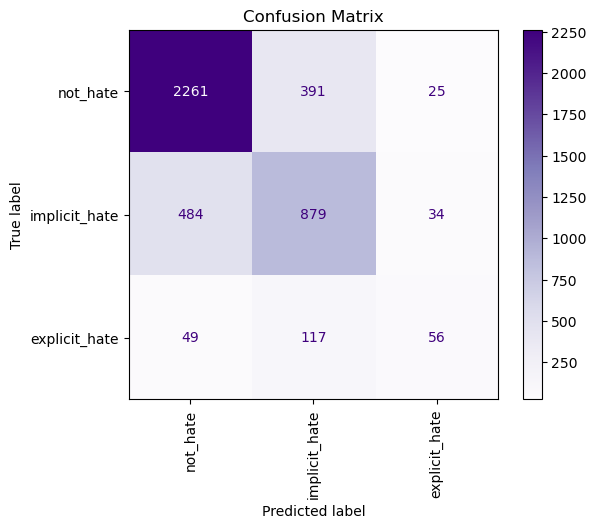

In [ ]:
evaluate_predictions(predicted_labels, gold_labels, label_list)

In [ ]:
print(tokenized_datasets_dev[0].keys())

posts = [example['post'] for example in tokenized_datasets_dev]  # adjust field name as needed

df = pd.DataFrame({
    "post": posts,
    "predicted_label": predicted_labels,
    "gold_label": gold_labels,
})
df.to_csv("HateBERTpredictions_vs_gold_train_dev.csv", index=False)

dict_keys(['post', 'class', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions.tolist(), references=labels.tolist())["accuracy"],
        "f1": f1_metric.compute(predictions=predictions.tolist(), references=labels.tolist(), average="weighted")["f1"],
    }


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, set_seed
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

SEED = 15
set_seed(SEED)


model_name = model_checkpoint.split("/")[-1]

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3
)

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-{task}",
    eval_strategy="epoch",  # Updated to use current parameter name
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

trainer1 = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_test,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/vd/xkcxq0p96sxd5bgjgdng13s00000gn/T/ipykernel_46406/2463675479.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer1 = Trainer(


In [ ]:
trainer1.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.687200,0.564142,0.750000,0.735420
2,0.405600,0.596404,0.757914,0.755457


TrainOutput(global_step=1612, training_loss=0.5309286993135589, metrics={'train_runtime': 142459.5808, 'train_samples_per_second': 0.181, 'train_steps_per_second': 0.011, 'total_flos': 2300737725262368.0, 'train_loss': 0.5309286993135589, 'epoch': 2.0})

In [ ]:
trainer1.evaluate()

{'eval_loss': 0.5964035987854004,
 'eval_accuracy': 0.7579143389199255,
 'eval_f1': 0.7554570376270061,
 'eval_runtime': 805.3249,
 'eval_samples_per_second': 5.334,
 'eval_steps_per_second': 0.334,
 'epoch': 2.0}

In [ ]:
predictions, labels, _ = trainer1.predict(tokenized_datasets_test)
predicted_indices = np.argmax(predictions, axis=1)


In [ ]:
label_list = ["not_hate", "implicit_hate", "explicit_hate"]

predicted_labels = [label_list[i] for i in predicted_indices]
gold_labels = [label_list[i] for i in labels]

Accuracy: 0.7579143389199255
Classification Report:
                precision    recall  f1-score   support

     not_hate     0.8297    0.8353    0.8325      2695
implicit_hate     0.6434    0.6686    0.6557      1406
explicit_hate     0.5328    0.3333    0.4101       195

     accuracy                         0.7579      4296
    macro avg     0.6686    0.6124    0.6328      4296
 weighted avg     0.7553    0.7579    0.7555      4296



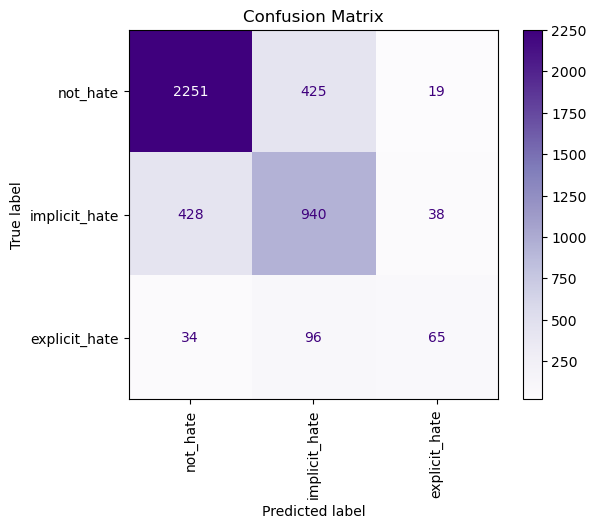

In [ ]:
evaluate_predictions(predicted_labels, gold_labels, label_list)
